In [1]:
import os
import sys
import cv2
import numpy as np
import torch.utils.data
from PIL import Image
import torch
import torchvision
import pytorch3d as p3d
from pytorch3d.utils import cameras_from_opencv_projection
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.vis.plotly_vis import plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    AmbientLights,
    RasterizationSettings,
    MeshRendererWithFragments,
    MeshRasterizer,
    SoftPhongShader,
    TexturesUV,
    PointsRasterizationSettings,
    PointsRasterizer,
    PointsRenderer,
    AlphaCompositor,
    NormWeightedCompositor,
    PointLights,
    MeshRenderer
)
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
import imageio
from pathlib import Path
import math
from sklearn.preprocessing import normalize

In [31]:
class Multiface():
    def __init__(self, resolution=1024):
        super(Multiface, self).__init__()
        self.resolution = resolution
        if torch.cuda.is_available():
            self.device = torch.device("cuda:0")
            torch.cuda.set_device(self.device)
        else:
            raise Exception('gpu unavailable')
    
    def load_obj(self, obj_path=None, tex_path=None, bin_path=None):
        vertices = []
        faces_vertex, faces_uv = [], []
        uvs = []
        with open(obj_path, "r") as f:
            for s in f:
                l = s.strip()
                if len(l) == 0:
                    continue
                parts = l.split(" ")
                if parts[0] == "vt":
                    uvs.append([float(x) for x in parts[1:]])
                elif parts[0] == "v":
                    vertices.append([float(x) for x in parts[1:]])
                elif parts[0] == "f":
                    faces_vertex.append([int(x.split("/")[0]) for x in parts[1:]])
                    faces_uv.append([int(x.split("/")[1]) for x in parts[1:]])
        # note that triangle ids are 0 indexed
        obj = {
            "verts": np.array(vertices, dtype=np.float32),
            "uvs": np.array(uvs, dtype=np.float32),
            "vert_ids": np.array(faces_vertex, dtype=np.int32) - 1,
            "uv_ids": np.array(faces_uv, dtype=np.int32) - 1,
        }
        verts = np.fromfile(bin_path, dtype=np.float32).reshape((-1, 3))
        tex = cv2.imread(tex_path).astype(np.float32)[..., ::-1] / 255.
        tex = cv2.resize(tex, (self.resolution, self.resolution))
        return obj, verts, tex
        
    def create_mesh(self, obj=None, verts=None, tex=None):
        """
        Args:
            maps: (N, H, W, C)
            faces_uvs: (N, F, 3) LongTensor, index into verts_uvs
            verts_uvs: (N, V, 2) FloatTensor, uv coordinates of each vetex
            
        """
        device = self.device
        faces_uvs = obj['uv_ids']
        verts_uvs = obj['uvs']
        faces = obj['vert_ids']
    
        faces_uvs = torch.LongTensor(faces_uvs).unsqueeze(0).to(device)
        verts_uvs = torch.FloatTensor(verts_uvs).unsqueeze(0).to(device)
        tex = torch.FloatTensor(tex).unsqueeze(0).to(device)
        faces = torch.LongTensor(faces).unsqueeze(0).to(device)
        
        verts_mean = np.mean(verts, axis=0)
        verts -= verts_mean
        if verts is None:
            verts = torch.FloatTensor(obj['verts']).unsqueeze(0).to(device)
        else:
            verts = torch.FloatTensor(verts).unsqueeze(0).to(device)

        texture = TexturesUV(tex, faces_uvs, verts_uvs)
        mesh = Meshes(verts, faces, texture)
        return mesh
    
    def norm_depth(self, depth, zfar=400, znear=0, denorm=False):
        if not denorm:
            mask = (depth == -1)
            depth = 255 * depth / zfar
            depth[mask] = 255
        else:
            mask = (depth == 255)
            depth = depth.astype(np.float32) * zfar / 255.
            depth[mask] = -1
        return depth
    
    def mesh2rgbd(self, mesh, dist=250, elev=0, azim=0, zfar=400, znear=1):
        device = self.device
        resolution = self.resolution
        
        R, T = look_at_view_transform(dist, elev, azim)
        cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=device)
        raster_settings = RasterizationSettings(
            image_size=resolution,
            blur_radius=0.0,
            faces_per_pixel=1
        )
        lights = AmbientLights(device=device)
        renderer = MeshRendererWithFragments(
            rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings).to(device),
            shader=SoftPhongShader(cameras=cameras, lights=lights).to(device)
        )

        color, fragments = renderer(mesh)
        depth = fragments.zbuf
        color = color[0, ..., :3].cpu().numpy() * 255
        color = color.astype(int)
        depth = depth[0, ..., :3].cpu().numpy()[:, :, 0]
        depth_norm = self.norm_depth(depth.copy(), zfar=zfar)
        mask = (color==255)
        color[mask] = 255
        return color, depth, cameras
    
    def rgbd2cloud(self, color, depth, cameras=None):
        device = self.device
        resolution = self.resolution
        
        mask = (depth >= 0)
        y_mat = np.arange(resolution)[:, None].repeat(resolution, axis=1).astype(np.float32)
        y_mat = - y_mat * 2 / (resolution - 1) + 1
        x_mat = y_mat.T
        xy_depth = np.stack([x_mat, y_mat, depth], axis=2)
        xy_depth = xy_depth[mask, :]
        feats = color[mask, :]

        xy_depth = torch.FloatTensor(xy_depth).unsqueeze(0).to(device)
        feats = torch.FloatTensor(feats).unsqueeze(0).to(device)
        points = cameras.unproject_points(xy_depth, scaled_depth_input=False, world_coordinates=True, in_ndc=True)
        cloud = Pointclouds(points=points, features=feats)
        return cloud
    
    def cloud2rgb(self, cloud, dist=250, elev=15, azim=15, zfar=400, znear=1):
        device = self.device
        resolution = self.resolution
        
        R, T = look_at_view_transform(dist, elev, azim)
        cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=device)

        raster_settings = PointsRasterizationSettings(
            image_size=resolution,
            radius=0.003,
            points_per_pixel=10
        )
        rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
        compositor = NormWeightedCompositor(background_color=(255, 255, 255))
        renderer = PointsRenderer(
            rasterizer=rasterizer,
            compositor=compositor
        ).to(device)

        color = renderer(cloud)[0, ..., :3].cpu().numpy().astype(int)
        mask = (color==255)
        color[mask] = 255
        return color
    
#     def cloud2rgb_new(self, cloud, krt, obj_pose, zfar=400, znear=1):
#         def norm_vec(x):
#             return x / np.linalg.norm(x)
        
#         extrin, intrin = krt["extrin"], krt["intrin"]
#         w2c_rot = extrin[:3, :3]
#         w2c_t = extrin[:3, 3]

#         w2o_rot = obj_pose[:3, :3]
#         w2o_t = obj_pose[:3, 3]
    
#         cam_pos = (-w2c_rot.T @ w2c_t[..., None]).ravel()
# #         at = (-w2o_rot.T @ w2o_t[..., None]).ravel()
#         at = np.array([0, 0, 0])
#         cam_pos[0] *= -1
#         cam_pos[2] *= -1
# #         at[0] *= -1
# #         at[2] *= -1
    
#         z_axis = norm_vec(at - cam_pos)
#         up = np.array([0, 1, 0])
#         x_axis = norm_vec(np.cross(up, z_axis))
#         y_axis = norm_vec(np.cross(z_axis, x_axis))
    
#         R = np.vstack((x_axis, y_axis, z_axis))
# #         T = (-R @ cam_pos[:, None])[:, 0]
#         T = np.array([1e-5, 1e-5, 300])

#         device = self.device
#         resolution = self.resolution
#         R = torch.FloatTensor(R.transpose((1, 0))).unsqueeze(0).to(device)
#         T = torch.FloatTensor(T).unsqueeze(0).to(device)
#         print(R)
#         print(T)
#         cameras = FoVPerspectiveCameras(zfar=zfar, R=R, T=T, device=device)

#         raster_settings = PointsRasterizationSettings(
#             image_size=resolution,
#             radius=0.003,
#             points_per_pixel=10
#         )
#         rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
#         compositor = NormWeightedCompositor(background_color=(255, 255, 255))
#         renderer = PointsRenderer(
#             rasterizer=rasterizer,
#             compositor=compositor
#         ).to(device)

#         color = renderer(cloud)[0, ..., :3].cpu().numpy().astype(int)
#         mask = (color==255)
#         color[mask] = 0
#         return color
    
   
    
    def load_krt(self, path):
        cameras = {}
        with open(path, "r") as f:
            while True:
                name = f.readline()
                if name == "":
                    break
                intrin = [[float(x) for x in f.readline().split()] for i in range(3)]
                dist = [float(x) for x in f.readline().split()]
                extrin = [[float(x) for x in f.readline().split()] for i in range(3)]
                f.readline()

                cameras[name[:-1]] = {
                    "intrin": np.array(intrin),
                    "dist": np.array(dist),
                    "extrin": np.array(extrin),
                }
                
    def load_raw(self, raw_path, crop=[0, 1024, 0, 1024]):
        h1, hl, w1, wl = crop
        h2 = h1 + hl - 1
        w2 = w1 + wl - 1
        raw = cv2.imread(raw_path).astype(np.float32)[..., ::-1] / 255.
        raw_cropped = cv2.resize(raw[h1:h2, w1:w2], (self.resolution, self.resolution))
        return raw_cropped
    
    

In [24]:
root_dir = '/home/tungi/datasets/multiface'
entity = 'm--20180227--0000--6795937--GHS'
# action = 'E061_Lips_Puffed'
action = 'E057_Cheeks_Puffed'
cam = '400023'
# timing = '023503'
timing = '021912'

obj_path = os.path.join(root_dir, entity, 'tracked_mesh', action, '{}.obj'.format(timing))
tex_path = os.path.join(root_dir, entity, 'unwrapped_uv_1024', action, cam, '{}.png'.format(timing))
# tex_mean_path = os.path.join(root_dir, entity, 'tex_mean.png')
tex_mean_path = os.path.join(root_dir, entity, 'unwrapped_uv_1024', action, 'average', '{}.png'.format(timing))
bin_path = os.path.join(root_dir, entity, 'tracked_mesh', action, '{}.bin'.format(timing))
krt_path = os.path.join(root_dir, entity, 'KRT')
trans_path = os.path.join(root_dir, entity, 'tracked_mesh', action, '{}_transform.txt'.format(timing))
raw_path = os.path.join(root_dir, entity, 'images', action, cam, '{}.png'.format(timing))

In [2]:
# # 40023
# int_mat = np.array([
#     [5069.297, 0, 600.5907],
#     [0, 5068.6997, 1016.2735],
#     [0, 0, 1]
# ])
# ext_mat = np.array([
#     [0.9956278, -0.0052650357, -0.0932603, 121.17298],
#     [0.0041177114, 0.9999135, -0.012490546, -0.52072936],
#     [0.093318, 0.012051917, 0.9955634, 34.179264]
# ])

Text(0.5, 1.0, 'Raw')

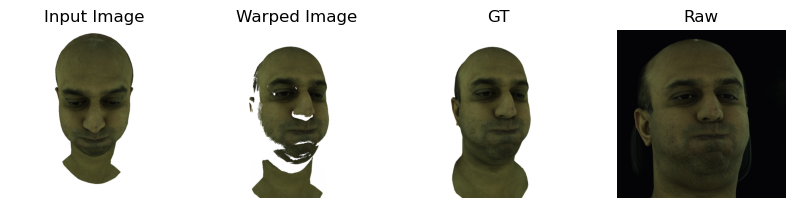

In [41]:
m = Multiface()
obj, verts, tex = m.load_obj(obj_path=obj_path, tex_path=tex_mean_path, bin_path=bin_path)
mesh = m.create_mesh(obj=obj, verts=verts, tex=tex)

dist, elev, azim = (300, 0, -16)

color, depth, cameras = m.mesh2rgbd(mesh, dist=dist, elev=24, azim=0)
color_gt, _, _ = m.mesh2rgbd(mesh, dist=dist, elev=elev, azim=azim)
cloud = m.rgbd2cloud(color, depth, cameras=cameras)

krt = m.load_krt(krt_path)
trans = np.genfromtxt(trans_path)
color_new = m.cloud2rgb(cloud, dist=dist, elev=elev, azim=azim)

color_raw = m.load_raw(raw_path, crop=[220, 1300, 100, 1300])

fig, axis = plt.subplots(1, 4, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')
axis[3].axis('off')

axis[0].imshow(color)
axis[0].set_title('Input Image')
axis[1].imshow(color_new)
axis[1].set_title('Warped Image')
axis[2].imshow(color_gt)
axis[2].set_title('GT')
axis[3].imshow(color_raw)
axis[3].set_title('Raw')

In [ ]:
def normalize(x):
    return x / np.linalg.norm(x)

def viewmatrix(z, up, pos):
    vec2 = normalize(z)
    vec1_avg = up
    vec0 = normalize(np.cross(vec1_avg, vec2))
    vec1 = normalize(np.cross(vec2, vec0))
    m = np.stack([vec0, vec1, vec2, pos], 1)
    return m

Text(0.5, 1.0, 'Raw')

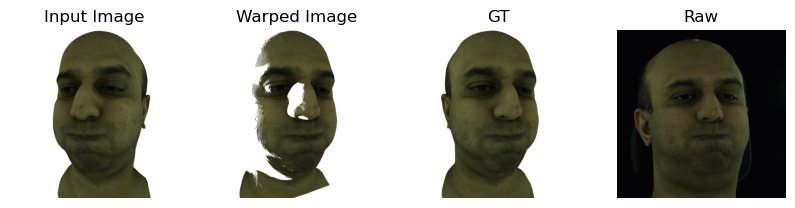

In [25]:
m = Multiface()
obj, verts, tex = m.load_obj(obj_path=obj_path, tex_path=tex_mean_path, bin_path=bin_path)
mesh = m.create_mesh(obj=obj, verts=verts, tex=tex)

dist, elev, azim = (240, 0, -16)

color, depth, cameras = m.mesh2rgbd(mesh, dist=dist, elev=0, azim=15)
color_gt, _, _ = m.mesh2rgbd(mesh, dist=dist, elev=elev, azim=azim)
cloud = m.rgbd2cloud(color, depth, cameras=cameras)

krt = m.load_krt(krt_path)
trans = np.genfromtxt(trans_path)
color_new = m.cloud2rgb(cloud, dist=dist, elev=elev, azim=azim)

color_raw = m.load_raw(raw_path, crop=[220, 1300, 100, 1300])

fig, axis = plt.subplots(1, 4, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')

axis[0].imshow(color)
axis[0].set_title('Input Image')
axis[1].imshow(color_new)
axis[1].set_title('Warped Image')
axis[2].imshow(color_gt)
axis[2].set_title('GT')

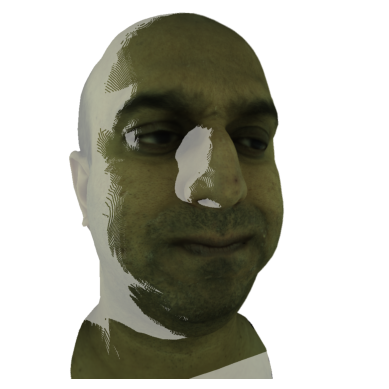

In [16]:
im_mix = (color_new + color_gt) / 2
plt.axis('off')
plt.imshow(im_mix.astype(np.int32))

Text(0.5, 1.0, 'Raw')

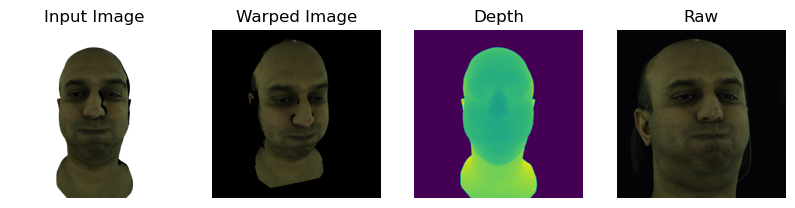

In [21]:
m = Multiface()
obj, verts, tex = m.load_obj(obj_path=obj_path, tex_path=tex_path, bin_path=bin_path)
mesh = m.create_mesh(obj=obj, verts=verts, tex=tex)
color, depth, cameras = m.mesh2rgbd(mesh, dist=300, elev=0, azim=0)
cloud = m.rgbd2cloud(color, depth, cameras=cameras)

krt = m.load_krt(krt_path)
trans = np.genfromtxt(trans_path)

color_new = m.cloud2rgb(cloud, dist=300, elev=15, azim=-15)

color_raw = m.load_raw(raw_path, crop=[220, 1300, 100, 1300])

fig, axis = plt.subplots(1,4, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')
axis[3].axis('off')

axis[0].imshow(color)
axis[0].set_title('Input Image')
axis[1].imshow(color_new)
axis[1].set_title('Warped Image')
axis[2].imshow(depth)
axis[2].set_title('Depth')
axis[3].imshow(color_raw)
axis[3].set_title('Raw')

Text(0.5, 1.0, 'Depth')

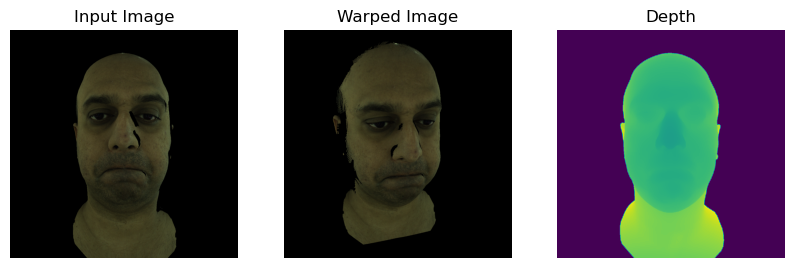

In [45]:
m = Multiface()
obj, verts, tex = m.load_obj(obj_path=obj_path, tex_path=tex_path, bin_path=bin_path)
mesh = m.create_mesh(obj=obj, verts=verts, tex=tex)
color, depth, cameras = m.mesh2rgbd(mesh, dist=300, elev=0, azim=0)

cloud = m.rgbd2cloud(color, depth, cameras=cameras)
color_new = m.cloud2rgb(cloud, dist=300, elev=15, azim=-15)

fig, axis = plt.subplots(1,3, figsize=(10,20))
axis[0].axis('off')
axis[1].axis('off')
axis[2].axis('off')

axis[0].imshow(color)
axis[0].set_title('Input Image')
axis[1].imshow(color_new)
axis[1].set_title('Warped Image')
axis[2].imshow(depth)
axis[2].set_title('Depth')

In [6]:
def render_path_spiral(elev_range=30, azim_range=30, stride=1):
#     elev_mat = np.arange(elev_range+1)[:, None].repeat(elev_range+1, axis=1).astype(np.float32)
#     elev_mat -= elev_range/2 
#     azim_mat = elev_mat.T
#     path_mat = np.stack([elev_mat, azim_mat], axis=2)
    path = []
    e_mat = np.linspace(0, elev_range, int(elev_range / stride) + 1) - elev_range / 2
    a_mat = np.linspace(0, azim_range, int(azim_range / stride) + 1) - azim_range / 2
    for i in range(a_mat.shape[0]):
        path.append((e_mat[-1], a_mat[i]))
    for i in range(1, e_mat.shape[0]):
        path.append((e_mat[-i-1], a_mat[-1]))
    for i in range(1, a_mat.shape[0]):
        path.append((e_mat[0], a_mat[-i-1]))
    for i in range(1, e_mat.shape[0]):
        path.append((e_mat[i], a_mat[0]))
    return path

In [7]:
output_dir = os.path.join(os.getcwd(), 'output/{}'.format(express), '{}_{}'.format(cam, timing))
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

render_path = render_path_spiral()
cnt = 0
for (e, a) in tqdm(render_path):
    color = m.cloud2rgb(cloud, dist=300, elev=e, azim=a)
    file_name = os.path.join(output_dir, '{}.png'.format(cnt))
    cv2.imwrite(file_name, color[..., ::-1].copy())
    cnt += 1


  0%|          | 0/121 [00:00<?, ?it/s]

In [8]:
frames = []
for i in range(cnt):
    im_path = os.path.join(output_dir, '{}.png'.format(i))
    im = imageio.v2.imread(im_path)
    frames.append(im)
imageio.mimwrite(os.path.join(output_dir, 'video.mp4'), frames, fps=60, quality=8)

In [27]:
def normalize(x):
    return x / np.linalg.norm(x)


for theta in np.linspace(0., 2. * np.pi, N + 1)[:-1]:

array([[-30., -30., -30., ..., -30., -30., -30.],
       [-29., -29., -29., ..., -29., -29., -29.],
       [-28., -28., -28., ..., -28., -28., -28.],
       ...,
       [ 28.,  28.,  28., ...,  28.,  28.,  28.],
       [ 29.,  29.,  29., ...,  29.,  29.,  29.],
       [ 30.,  30.,  30., ...,  30.,  30.,  30.]], dtype=float32)